In [16]:
###############################################################################
# 
# author: Jonathan Fisher
#         j.fisher@fz-juelich.de
#         jonathan.m.fisher@gmail.com
#
# description:
#     generates (obviously fake) simulated biodiff data,
#  with and without slowly varying background. This is used
#  in functional tests of nsxlib.
#
###############################################################################

import numpy as np
import math
import pynsx as nsx
import h5py

pi2 = np.pi / 2.0
wavelength = 2.67
dmin = 2.5
dmax = 50.0
infile = "/home/jonathan/git/nsxtool/tests/data/blank.hdf"
outfile = "/home/jonathan/git/nsxtool/tests/data/simulated.hdf"

#group_name = "P 21 21 21"
group_name = "P 1"
group = nsx.SpaceGroup(group_name)

from matplotlib import pyplot as plt

def correct_image(image):
    baseline = 227.0
    gain = 8.0
    return gain*(image+baseline)

def poisson_noise(image):
    return np.sqrt(image)*np.random.normal(0, 1, image.shape)

exp = nsx.Experiment("Simulated", "BioDiff2500")
diff = exp.getDiffractometer()
reader = nsx.HDF5DataReader(infile, diff)
data = nsx.DataSet(reader, diff)
exp.addData(data)

A = np.diag([43., 53., 61.])
U = np.random.rand(3,3)
U = np.identity(3) + U.dot(U.transpose())
_, U = np.linalg.eig(U)

uc = nsx.UnitCell(U.dot(A))
ch = nsx.CellCharacter(uc.metric())
print(ch.a, ch.b, ch.c)
uc.niggliBasis()

uc.setSpaceGroup(group_name)

det_shape = nsx.Ellipsoid(np.array([800.0, 450.0, 10.0]), 5.0)
peak = nsx.Peak3D(data, det_shape)
peak.setSelected(True)

hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)
len(hkls)

43.0 53.00000000000001 61.0


37244

In [17]:
print(data.nFrames())

166


In [18]:
qs = nsx.ReciprocalVectorList()
B = uc.reciprocalBasis()

for hkl in hkls:
    q = hkl.rowVector().dot(B)
    qs.push_back(nsx.ReciprocalVector(q))

In [19]:
events = data.getEvents(qs)
len(events)

8800

In [20]:
sigmaD = 0.3
sigmaM = 0.2

peaks = []

for event in events:
    center = np.array([event._px, event._py, event._frame])
    peak = nsx.Peak3D(data, nsx.Ellipsoid(center, 5.0))
    coords = nsx.PeakCoordinateSystem(peak)
    shape = coords.detectorShape(sigmaD, sigmaM)
    peak.setShape(shape)
    peaks.append(peak)

In [21]:
A = np.random.rand(3,3)
A /= np.linalg.norm(A)
A = 0.5*np.identity(3) + A.dot(A.transpose())
A /= np.linalg.norm(A)
A *= 50


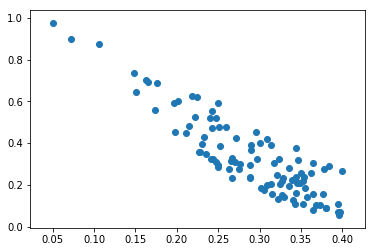

In [22]:
import random
from matplotlib import pyplot as plt

qs = []
Is = []

for i in range(100):
    peak = random.sample(peaks, 1)[0]
    q = peak.q().rowVector()
    qs.append(np.linalg.norm(q))
    
    new_I = 0
    
    elements = group.groupElements()
    for el in elements:
        g = el.getRotationPart()
        gq = q.dot(g)
        new_I += np.exp(-gq.dot(A).dot(gq.transpose()).trace() / 2.0)
        
    I = new_I / len(elements)    
    Is.append(I)
    #print(I)
       
        
plt.scatter(qs, Is)
plt.show()

In [23]:
np.linalg.eig(A)

(array([41.10771622, 16.42041603, 23.24920653]),
 array([[ 0.6295385 ,  0.772698  ,  0.08135774],
        [ 0.52919208, -0.34975106, -0.77306528],
        [ 0.56889104, -0.52972823,  0.62908742]]))

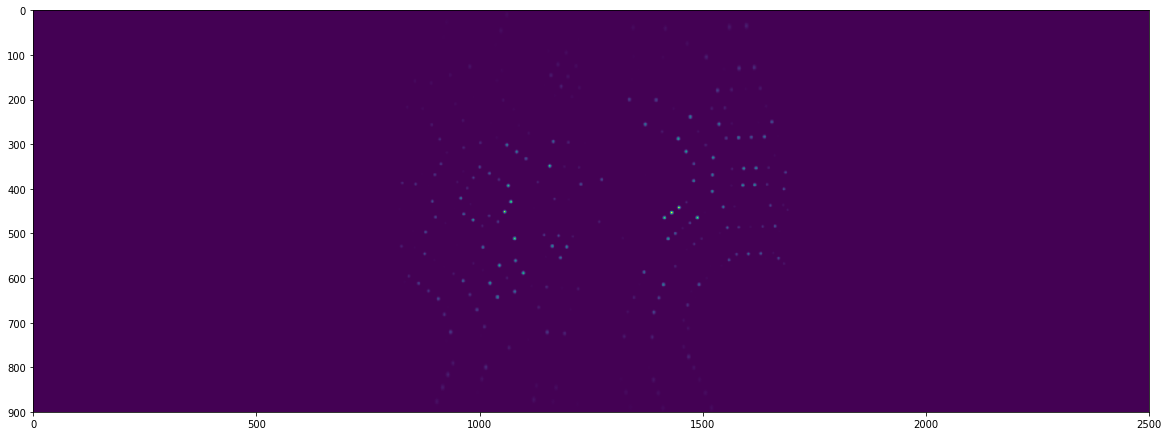

In [24]:
def frame_peaks(idx, peaks, nsigma):
    in_frame = []
    
    for peak in peaks:
        center = peak.getShape().center()
        extents = peak.getShape().aabb().extents()
        
        df = extents[2] / 2.0
        
        if abs(center[2]-idx) > nsigma*df:
            continue
            
        in_frame.append(peak)
        
    return in_frame


def generate_frame(idx, peaks):
    Imax = 200**2
    nsigma = 4
    image = np.array(data.frame(idx), dtype=np.float)
    rows, cols = image.shape
       
    in_frame = frame_peaks(idx, peaks, nsigma)
    #print(len(in_frame))
    elements = group.groupElements()
    gs = [ el.getRotationPart() for el in elements ]
    
    for peak in in_frame:
        aabb = peak.getShape().aabb()
        shape = peak.getShape()
        center = shape.center()
        inv_cov = shape.metric()
        extents = aabb.extents()
        
        I = 0        
        q = peak.q().rowVector().transpose()        
        
        for g in gs:
            gq = g.dot(q)
            I += Imax * np.exp(-0.5*gq.transpose().dot(A).dot(gq).trace())
            
        I /= len(gs)
        #print("intensity", I)
        
        xmin = int(center[0,0] - nsigma*extents[0,0]/2)
        xmax = int(center[0,0] + nsigma*extents[0,0]/2)
        
        ymin = int(center[1,0] - nsigma*extents[1,0]/2)
        ymax = int(center[1,0] + nsigma*extents[1,0]/2)
        
        zmin = int(center[2,0] - nsigma*extents[2,0]/2)
        zmax = int(center[2,0] + nsigma*extents[2,0]/2)
        
        xmin = max(0, xmin)
        xmax = min(data.nCols(), xmax)
        
        ymin = max(0, ymin)
        ymax = min(data.nRows(), ymax)
        
        zmin = max(0, zmin)
        zmax = min(data.nFrames(), zmax)
        
        x = range(xmin, xmax)
        y = range(ymin, ymax)
        #z = range(zmin, zmax)
        z = idx
        
        #print("x:", x)
        #print("y:", y)
        
        #print("dx:", np.array(x)-center[0,0])
        #print("dy:", np.array(y)-center[1,0])
        
        x, y = np.meshgrid(x, y)
        
        
        
        dx = x-center[0,0]
        dy = y-center[1,0]
        dz = z-center[2,0]
        
        
        #print("dx", dx.transpose())
        
        M = shape.metric()
        #print(M.shape)
        #print(dx.shape)
        #print(x.shape)
        arg = dx**2 * M[0,0] + dy**2 * M[1,1] + dz**2 * M[2,2]
        arg += 2*dx*dy*M[0,1] + 2*dx*dz*M[0,2] + 2*dy*dz*M[1,2]
        
        #print("arg:", arg)
        
        
        coef = np.sqrt(np.linalg.det(M/2/np.pi))
        #print("coef:", coef)
        
        inten = coef*I * np.exp(-0.5*arg)
        #print("integrated intensity", inten.sum())
        image[ymin:ymax, xmin:xmax] += inten   
        
        #break
    
    return image

im = generate_frame(50, peaks)
plt.figure(figsize=(20,10))
plt.imshow(im)
plt.show()

In [25]:
param = nsx.IndexerParameters()
param.maxdim = 100.0
param.minUnitCellVolume = 20*20*20
#param.nVertices = 1000

In [26]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())


for peak in peaks:
    indexer.addPeak(peak)
    
indexer.autoIndex(param)

In [27]:
solns = indexer.getSolutions()

for sln in solns:
    fit_uc, score = sln
    ch = nsx.CellCharacter(fit_uc.metric())
    print(ch.a, ch.b, ch.c, score)

43.00000000000002 53.00000000000008 60.999999999999716 100.0
42.999999999999986 52.99999999999999 60.999999999999964 100.0
43.0 53.00000000000002 60.99999999999995 100.0
43.0 53.00000000000001 61.0 100.0
42.99999999999982 53.00000000000015 61.00000000000015 100.0
43.00000000000005 53.000000000000036 61.00000000000004 100.0
43.0 53.00000000000001 182.99999999999991 100.0
68.24954212300624 61.00000000000002 101.0198000393981 100.0
74.63243262818116 53.0 142.69547995644427 100.0
52.99999999999999 61.0 215.00000000000006 100.0
101.01980003939823 60.99999999999999 114.38968484964023 100.0
53.00000000000001 61.0 215.00000000000014 100.0
52.99999999998883 74.63211778336863 210.87418080991 100.0
43.0 53.000000000000014 365.9999999999999 100.0
80.80841540334767 118.00847427197758 129.63795740445758 100.0
85.99999999999994 105.99999999999999 121.99999999999999 100.0
74.63243262818115 118.00847427197769 129.63795740445772 100.0
80.80841540334767 118.00847427197778 129.63795740445826 100.0
101.019

In [28]:
1 / -0.07142857142857166

-13.999999999999954

In [29]:
COB = np.linalg.inv(solns[3][0].basis()).dot(uc.basis())
print(COB)
1.0 / np.linalg.det(COB)

[[-1.00000000e+00 -9.76949528e-16 -4.86819600e-16]
 [ 5.99622992e-16 -1.00000000e+00 -5.12347376e-16]
 [ 2.38283080e-17 -3.18317438e-16  1.00000000e+00]]


1.0000000000000002

In [30]:
print(solns[0][0].niggliBasis())
print(solns[0][0].basis())

[[-22.29296442  42.37011306  18.51436166]
 [-28.78493286  -8.40467485 -44.2716129 ]
 [-22.8790598  -30.71050243  37.65956324]]
[[-22.29296442  42.37011306  18.51436166]
 [-28.78493286  -8.40467485 -44.2716129 ]
 [-22.8790598  -30.71050243  37.65956324]]


In [33]:
im.mean()

0.3300163618306957

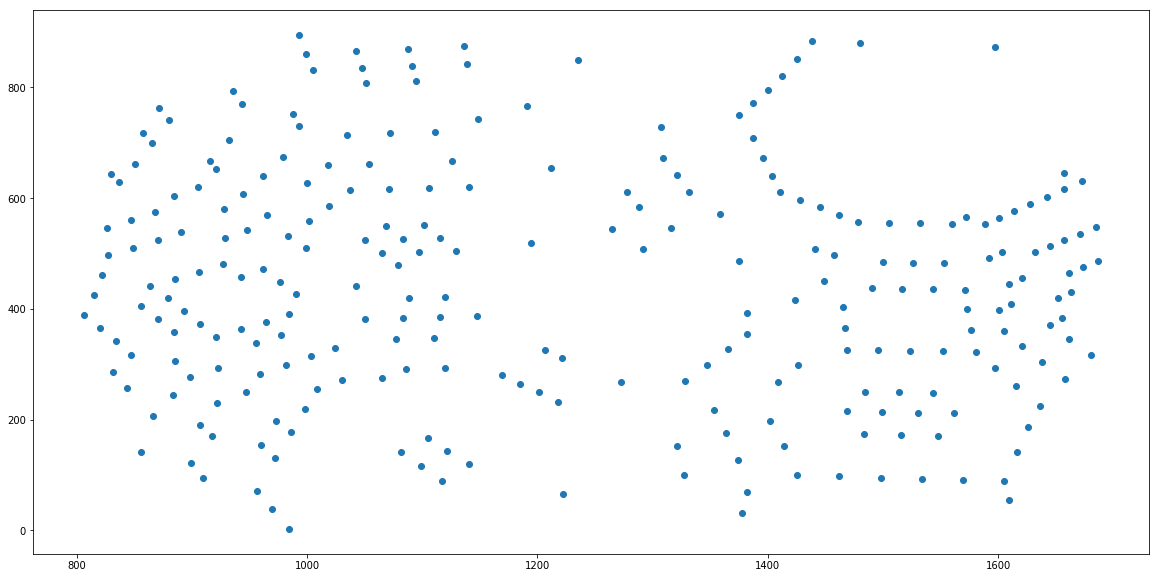

In [34]:
in_frame = frame_peaks(10, peaks, 3)

xs = []
ys = []

for peak in in_frame:
    c = peak.getShape().center()
    xs.append(c[0,0])
    ys.append(c[1,0])

plt.figure(figsize=(20,10))
plt.scatter(xs, ys)
plt.show()

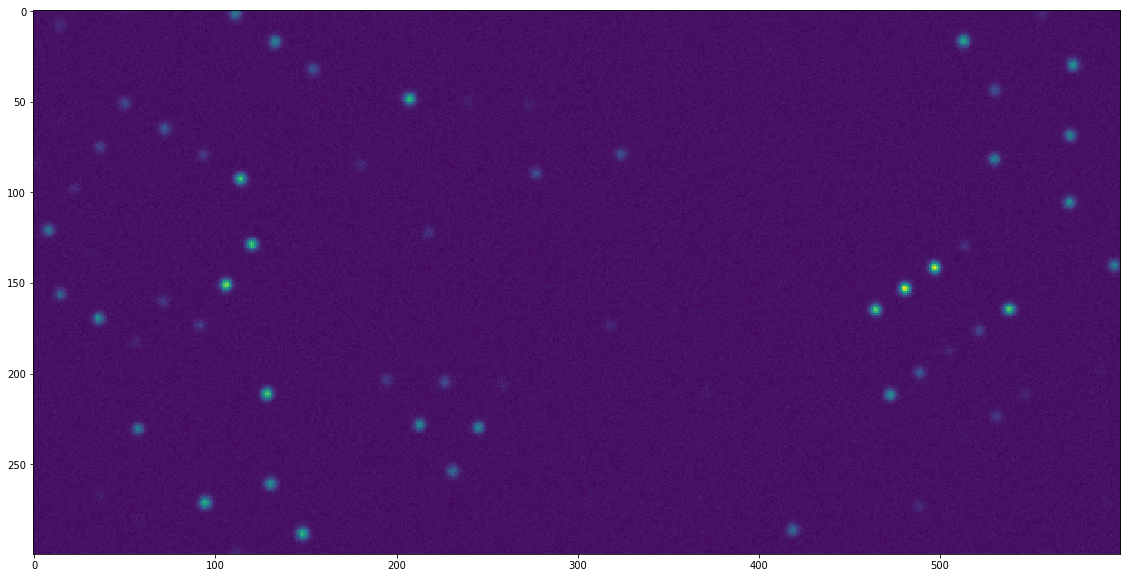

In [45]:
bkg = 40
noise = poisson_noise(bkg+im)
plt.figure(figsize=(20,10))
plt.imshow((bkg+im+noise)[300:600,950:1550])
plt.show()

In [17]:
noise.std()

6.353095804361979

In [18]:
im.mean()

0.3289927713283312

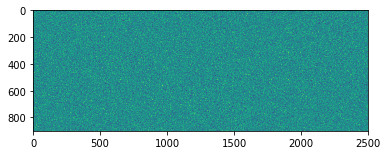

In [19]:
plt.imshow(noise)
plt.show()

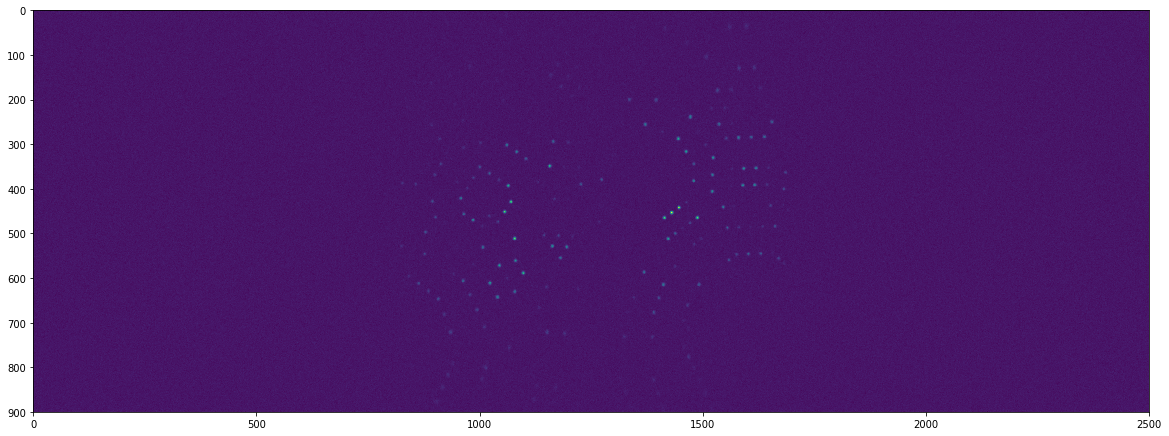

In [46]:
simulated = correct_image(bkg + noise + im)
plt.figure(figsize=(20,10))
plt.imshow(simulated)
plt.show()

In [48]:
def background():
    return 40.0

In [49]:
N = data.nFrames()
delta = 0.3 # hard coded!!

with h5py.File(outfile, "w") as f:
    data_grp = f.create_group("Data")
    scan = f.create_group("Data/Scan")
    expr = f.create_group("Experiment")
    info = f.create_group("Info")
    
    images = data_grp.create_dataset("Counts", (N, 900, 2500,), dtype='i4', compression="gzip", compression_opts=9)
    
    scan.create_dataset("Sample/chi", (N,), dtype="f8")
    omega = scan.create_dataset("Sample/omega", (N,), dtype="f8")
    scan.create_dataset("Sample/phi", (N,), dtype="f8")
    
    scan.create_dataset("Source/chi-mono", (N,), dtype="f8")
    scan.create_dataset("Source/om-mono", (N,), dtype="f8")
    scan.create_dataset("Source/phi-mono", (N,), dtype="f8")
    scan.create_dataset("Source/x-mono", (N,), dtype="f8")
    scan.create_dataset("Source/y-mono", (N,), dtype="f8")
    
    scan.create_dataset("Detector/2theta(gamma)", (N,), dtype="f8")
    
    expr.attrs.create("npdone", N, dtype="i4")
    expr.attrs.create("monitor", 0.0)
    expr.attrs.create("wavelength", 2.67)
    expr.attrs.create("Numor", 0, dtype="i4")
  
    info.attrs.create("Instrument", b"BioDiff2500")
    
       
    bkg = background()
        
    #for i in range(N):        
    for i in range(10):        
        simulated = generate_frame(i, peaks) + bkg
        noise = poisson_noise(simulated)        
        simulated += noise
        simulated = correct_image(simulated)
        images[i] = simulated
        omega[i] = i*delta
        
        print(i, images[i].mean())
        
        
    f.flush()
    f.close()
    
print("Done simulating data.")

0 2136.990093777778
1 2138.0617724444446
2 2138.1613533333334
3 2138.1604124444443
4 2138.3860075555554
5 2138.2581715555557
6 2138.121796888889
7 2138.086568
8 2138.004979111111
9 2138.1293977777777
Done simulating data.


In [ ]:
print(42)

In [ ]:
help(h5py.File)